# Data Analyst Nanodegree
## Project 1:  Investigate a dataset


## Titanic Survival Exploration

# 1. Introduction 

In 1912, the ship RMS Titanic struck an iceberg on its maiden voyage and sank, resulting in the deaths of most of its passengers and crew. In this introductory project, we will explore a subset of the RMS Titanic passenger manifest to determine which features best predict whether someone survived or did not survive. 

> Part of this work comes from previous work for the Machine Learning Nanodegree titled: [Project 0 - Titanic Survival Exploration](https://github.com/mabelvj/MLNP/tree/master/P0_titanic)


## 1.1. Questions 
The aim of this project is to analyze the dependance of the survival outcome of Titanic passenger of different factors. Hence, the **dependent** variable will be the survival of the passenger and the others will be remain as **independent** variables.

In this case, the efect on the survival of three independent features will be analyzed: class, sex and age.  It is logical to believe that higher class will result in higher possibility of survivals, as with females and younger people are more likely to survive.

The questions to ask is, then:
- How does class influence survival?
- How does gender influence survival?
- How does age influence survival?


## 1.2. Loading dataset

In [91]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import stats
import ipy_table as tbl

# RMS Titanic data visualization code 
#from titanic_visualizations import survival_stats
from IPython.display import display
%matplotlib inline

# Load the dataset
in_file = 'titanic-data.csv'
full_data = pd.read_csv(in_file)

# Print the first few entries of the RMS Titanic data
display(full_data.head(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 1.3. Feature description

From a sample of the RMS Titanic data, we can see the various features present for each passenger on the ship:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)


Since we're interested in the outcome of survival for each passenger or crew member, we can remove the **Survived** feature from this dataset and store it as its own separate variable `outcomes`. We will use these outcomes as our prediction targets.  
Run the code block cell to remove **Survived** as a feature of the dataset and store it in `outcomes`.


In [92]:
# Store the 'Survived' feature in a new variable and remove it from the dataset
outcomes = full_data['Survived']

# Select columns to keep
columns_to_keep= ['Pclass', 'Sex', 'Age']
titanic_df = full_data[columns_to_keep]

# Show the new dataset with 'Survived' removed
display(titanic_df.head(2))

,Pclass,Sex,Age
0,3,male,22.0
1,1,female,38.0


The very same sample of the RMS Titanic data now shows the **Survived** feature removed from the DataFrame. Note that `data` (the passenger data) and `outcomes` (the outcomes of survival) are now *paired*. That means for any passenger `data.loc[i]`, they have the survival outcome `outcome[i]`.

**Think:** *Out of the first five passengers, if we predict that all of them survived, what would you expect the accuracy of our predictions to be?*

# 2. Data wrangling and cleaning

## 2.1. Investigate dataset

Let us first investigate the content of the selected columns( class, sex and age) and check if there are any missing values.

In [93]:
# print out information about the data
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
Pclass    891 non-null int64
Sex       891 non-null object
Age       714 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 21.0+ KB


There are missing 77 missing ages.

## 2.2. Insert missing ages
For the age missing values it will be tried to apply 

In [94]:
#https://github.com/ghunt03/DAP02-Investigate-a-dataset/blob/master/Titanic%20Dataset%20Investigation.ipynb

missing_ages = titanic_df[titanic_df['Age'].isnull()]
# determine maximum and minimum age based on Sex and Pclass
quantiles_ages = titanic_df[titanic_df['Age'].notnull()].groupby(['Sex','Pclass'])['Age'].quantile([0.05,0.95])
print quantiles_ages


def remove_na_ages(row):
    '''
    function to check if the age is null and replace with the a random value int te 0.1-0.9 quantile range 
    for the class and sex
    '''
    #print quantiles_ages[row['Sex'],row['Pclass'],0.05],quantiles_ages[row['Sex'],row['Pclass'],0.95]
    if pd.isnull(row['Age']):
        return round(random.uniform(quantiles_ages[row['Sex'],row['Pclass'],0.05],
                                       quantiles_ages[row['Sex'],row['Pclass'],0.95]),3)# round element to 3 decimals
    else:
        return round(row['Age'],3) # convert to 3 decimals

titanic_df.head(3)


df = titanic_df.copy(deep = True)
df['Age'] = titanic_df.apply(remove_na_ages, axis=1)


Sex     Pclass      
female  1       0.05    16.00
                0.95    58.00
        2       0.05     4.65
                0.95    50.00
        3       0.05     2.00
                0.95    44.90
male    1       0.05    19.00
                0.95    65.00
        2       0.05     1.90
                0.95    57.20
        3       0.05     5.20
                0.95    47.00
Name: Age, dtype: float64


In [122]:
#Calculate the quantiles
quartiles = df['Age'].quantile([.0,.25,.5,.75, 1.])
print quartiles.values

df['Age_group'] = pd.cut(df['Age'], quartiles.values, labels=[1,2,3,4], precision= 3, include_lowest= True)

# transform categorical data into integer   

df['Sex_label'] =pd.Categorical.from_array(df['Sex'])

#Is a Factor, as in R. To access labels: f.labels
# To access levels: f.levels

[  0.42   20.     28.     38.366  80.   ]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: Categorical.from_array is deprecated, use Categorical instead


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: 'labels' is deprecated. Use 'codes' instead
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: 'labels' is deprecated. Use 'codes' instead
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: 'labels' is deprecated. Use 'codes' instead
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:33: FutureWarning: 'labels' is deprecated. Use 'codes' instead
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:44: FutureWarning: 'labels' is deprecated. Use 'codes' instead
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:45: FutureWarning: 'labels' is deprecated. Use 'codes' instead


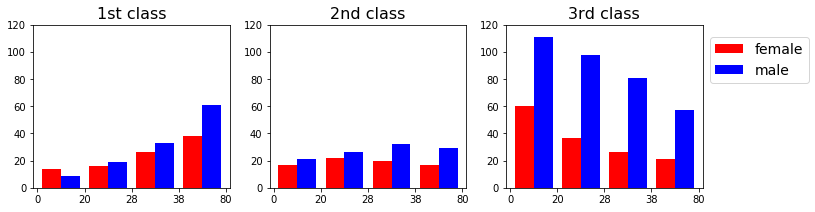

In [253]:
def place_legend_outside(ax):
    
    # Shrink current axis by 20%
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0.6), fontsize= 14)


    
fig = plt.figure(figsize=[12,3])
ax = fig.add_subplot(131)

age_labels=['0','%d'%(quartiles[.25]), '%d'%(quartiles[.5]), '%d'%(quartiles[.75]),'%d'%(quartiles[1.])]

limits= [0,120]


#First class, ages,gender
plt.subplot(131)
plt.hist([df['Age_group'][(df['Pclass']==1) & (df['Sex']== 'female')].values.labels,
          df['Age_group'][(df['Pclass']==1) & (df['Sex']== 'male')].values.labels], 
         color=['red', 'blue'], bins=[0, 1, 2, 3, 4], histtype='bar')
plt.title('1st class', fontsize = 16)
plt.xticks(range(5), age_labels)
plt.ylim(limits)


#Second class, ages,gender
plt.subplot(132)
plt.hist([df['Age_group'][(df['Pclass']==2) & (df['Sex']== 'female')].values.labels,
          df['Age_group'][(df['Pclass']==2) & (df['Sex']== 'male')].values.labels], 
         color=['red', 'blue'], bins=[0, 1, 2, 3, 4], histtype='bar')

plt.title('2nd class', fontsize = 16)
#plt.title('female')
plt.xticks(range(5), age_labels)
plt.ylim(limits)


#Third class, ages,gender
ax3= plt.subplot(133)
plt.hist([df['Age_group'][(df['Pclass']==3) & (df['Sex']== 'female')].values.labels,
          df['Age_group'][(df['Pclass']==3) & (df['Sex']== 'male')].values.labels], 
         color=['red', 'blue'], bins=[0, 1, 2, 3, 4], histtype='bar', label = ['female', 'male'] )

plt.title('3rd class', fontsize = 16)
plt.xticks(range(5), age_labels)
plt.ylim(limits)
plt.legend()

place_legend_outside(ax3)

In [256]:
table = pd.crosstab([outcomes], [df['Pclass'], df['Sex'],df['Age_group']])
#table = pd.crosstab([outcomes[df[df['Pclass']==1].index],outcomes[df[df['Pclass']==2].index], outcomes[df[df['Pclass']==3].index]])
print table
chi2, p, dof, expected = stats.chi2_contingency(table.values)
print expected
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
    
]
tbl.make_table(results)

Pclass         1                                   2     ...               3  \
Sex       female             male             female     ... male     female   
Age_group      1   2   3   4    1   2   3   4      1   2 ...    3   4      1   
Survived                                                 ...                   
0              1   1   0   1    5  10  19  43      0   3 ...   29  26     31   
1             13  15  26  37    4   9  14  18     17  19 ...    3   3     29   

Pclass                                  
Sex                   male              
Age_group   2   3   4    1   2   3   4  
Survived                                
0          16  13  12   93  85  69  53  
1          21  13   9   18  13  12   4  

[2 rows x 24 columns]
[[  8.62626263   9.85858586  16.02020202  23.41414141   5.54545455
   11.70707071  20.33333333  37.58585859  10.47474747  13.55555556
   12.32323232  10.47474747  12.93939394  16.02020202  19.71717172
   17.86868687  36.96969697  22.7979798   16.0202

Item,Value
Chi-Square Test,368.9552
P-Value,0.0000


In [290]:
survival_rate= (table.iloc[1]/table.sum(axis=0))

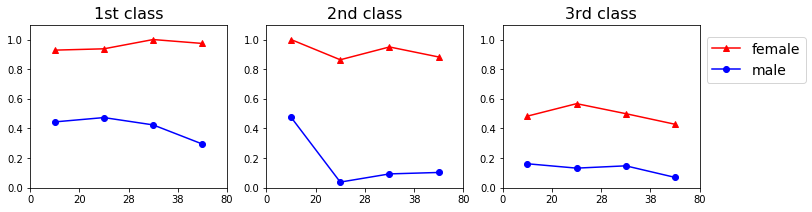

In [324]:
fig = plt.figure(figsize=[12,3])
ax = fig.add_subplot(131)

age_labels=['0','%d'%(quartiles[.25]), '%d'%(quartiles[.5]), '%d'%(quartiles[.75]),'%d'%(quartiles[1.])]

limits= [0,1.1]
x_values = np.arange(start= .5, stop= 4.5, step=1)

#First class, ages,gender
plt.subplot(131)
plt.plot(x_values,survival_rate[1]['female'].values, 'r-^')
plt.plot(x_values, survival_rate[1]['male'].values, 'b-o') 


plt.title('1st class', fontsize = 16)
plt.xticks(range(5), age_labels)
plt.ylim(limits)


#Second class, ages,gender
plt.subplot(132)

plt.plot(x_values,survival_rate[2]['female'].values, 'r-^')
plt.plot(x_values, survival_rate[2]['male'].values, 'b-o') 


plt.title('2nd class', fontsize = 16)
#plt.title('female')
plt.xticks(range(5), age_labels)
plt.ylim(limits)


#Third class, ages,gender
ax3= plt.subplot(133)

plt.plot(x_values,survival_rate[3]['female'].values, 'r-^', label= 'female')
plt.plot(x_values, survival_rate[3]['male'].values, 'b-o', label= 'male') 

plt.title('3rd class', fontsize = 16)

plt.xticks(range(5), age_labels)
plt.ylim(limits)
plt.legend()

place_legend_outside(ax3)

0.384
['female', 'male']


(0, 1.1)

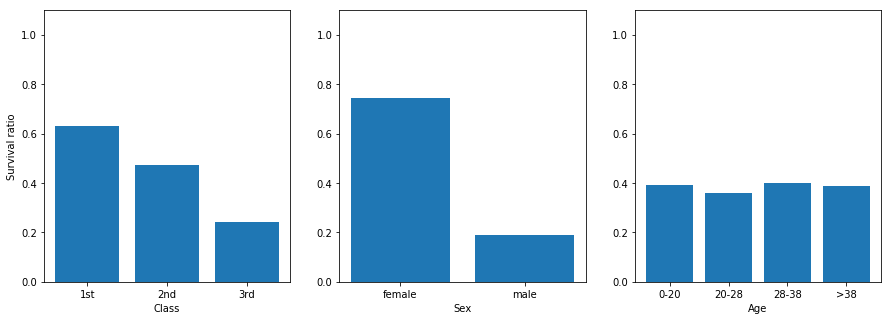

In [325]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(131)
limits= [0,1.1]

def survival_ratio(df):
    '''This function returns the survival ratio from from the dataframe introduced df'''
    return np.round(np.sum(df==1)/float(df.size),3)

print survival_ratio(outcomes)

#SURVIVAL

# Class
list_of_classes = sorted(df['Pclass'].unique())
survival_classes = [survival_ratio(outcomes[df[df['Pclass']==classes].index]) for classes in list_of_classes]


plt.subplot(131)

plt.bar(list_of_classes, survival_classes)
plt.xticks([1,2,3], ['1st', '2nd', '3rd'])
plt.xlabel('Class')
plt.ylabel('Survival ratio')
plt.ylim(limits)

#Sex

list_of_sex = sorted(df['Sex_label'].unique())
print list_of_sex
survival_sex = [survival_ratio(outcomes[df[df['Sex_label']==classes].index]) for classes in list_of_sex]


plt.subplot(132)

plt.bar(range(len(list_of_sex)), survival_sex)
#plt.xticks([1,2,3,4], ['0-%d'%quartiles[.25],'%d-%d'%(quartiles[.25],quartiles[.5]), '%d-%d'%(quartiles[.5],quartiles[.75]), '>%d'%(quartiles[.75])])
plt.xticks([0,1], list_of_sex)
plt.xlabel('Sex')
plt.ylabel('')
plt.ylim(limits)

#Ages
list_of_ages = sorted(df['Age_group'].unique())

survival_ages = [survival_ratio(outcomes[df[df['Age_group']==classes].index]) for classes in list_of_ages]


plt.subplot(133)

plt.bar(list_of_ages, survival_ages)
plt.xticks([1,2,3,4], 
           ['0-%d'%quartiles[.25],'%d-%d'%(quartiles[.25],quartiles[.5]), '%d-%d'%(quartiles[.5],quartiles[.75]), '>%d'%(quartiles[.75])])
plt.xlabel('Age')
plt.ylabel('')
plt.ylim(limits)




## 4. Chi-square tests

### 1. Class

In [120]:
table = pd.crosstab([outcomes], df['Pclass'])
#table = pd.crosstab([outcomes[df[df['Pclass']==1].index],outcomes[df[df['Pclass']==2].index], outcomes[df[df['Pclass']==3].index]])
print table
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
    
]
tbl.make_table(results)

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
[[ 133.09090909  113.37373737  302.53535354]
 [  82.90909091   70.62626263  188.46464646]] 2


Item,Value
Chi-Square Test,102.8890
P-Value,0.0000


## 2. Sex

In [116]:
table = pd.crosstab([outcomes], df['Sex_label'])
#table = pd.crosstab([outcomes[df[df['Pclass']==1].index],outcomes[df[df['Pclass']==2].index], outcomes[df[df['Pclass']==3].index]])
print table
chi2, p, dof, expected = stats.chi2_contingency(table.values)
print expected
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
    
]
tbl.make_table(results)

Sex_label  female  male
Survived               
0              81   468
1             233   109
[[ 193.47474747  355.52525253]
 [ 120.52525253  221.47474747]]


Item,Value
Chi-Square Test,260.7170
P-Value,0.0000


## 3. Age

In [178]:
table = pd.crosstab([outcomes], df['Age_group'])
print table
chi2, p, dof, expected = stats.chi2_contingency(table.values)
print expected
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
    
]
tbl.make_table(results)

Age_group    1    2    3    4
Survived                     
0          141  140  131  137
1           91   78   87   86
[[ 142.94949495  134.32323232  134.32323232  137.4040404 ]
 [  89.05050505   83.67676768   83.67676768   85.5959596 ]]


Item,Value
Chi-Square Test,0.9116
P-Value,0.8226


# OLD PROJECT

In [65]:
def accuracy_score(truth, pred):
    """ Returns accuracy score for input truth and predictions. """
    
    # Ensure that the number of predictions matches number of outcomes
    if len(truth) == len(pred): 
        
        # Calculate and return the accuracy as a percent
        return "Predictions have an accuracy of {:.2f}%.".format((truth == pred).mean()*100)
    
    else:
        return "Number of predictions does not match number of outcomes!"
    
# Test the 'accuracy_score' function
predictions = pd.Series(np.ones(5, dtype = int))
print accuracy_score(outcomes[:5], predictions)

Predictions have an accuracy of 60.00%.


Examining the survival statistics, a large majority of males did not survive the ship sinking. However, a majority of females *did* survive the ship sinking. Let's build on our previous prediction: If a passenger was female, then we will predict that they survived. Otherwise, we will predict the passenger did not survive.  
Fill in the missing code below so that the function will make this prediction.  
**Hint:** You can access the values of each feature for a passenger like a dictionary. For example, `passenger['Sex']` is the sex of the passenger.

In [24]:
def predictions_1(data):
    """ Model with one feature: 
            - Predict a passenger survived if they are female. """
    
    predictions = []
    for _, passenger in data.iterrows():
        
        if passenger['Sex']== 'female':
            predictions.append(1)
        else: #males are predicted to not survive
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_1(data)

### Question 2
*How accurate would a prediction be that all female passengers survived and the remaining passengers did not survive?*  
**Hint:** Run the code cell below to see the accuracy of this prediction.

In [25]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 78.68%.


**Answer**: 78.68%

Using just the **Sex** feature for each passenger, we are able to increase the accuracy of our predictions by a significant margin. Now, let's consider using an additional feature to see if we can further improve our predictions. Consider, for example, all of the male passengers aboard the RMS Titanic: Can we find a subset of those passengers that had a higher rate of survival? Let's start by looking at the **Age** of each male, by again using the `survival_stats` function. This time, we'll use a fourth parameter to filter out the data so that only passengers with the **Sex** 'male' will be included.  
Run the code cell below to plot the survival outcomes of male passengers based on their age.

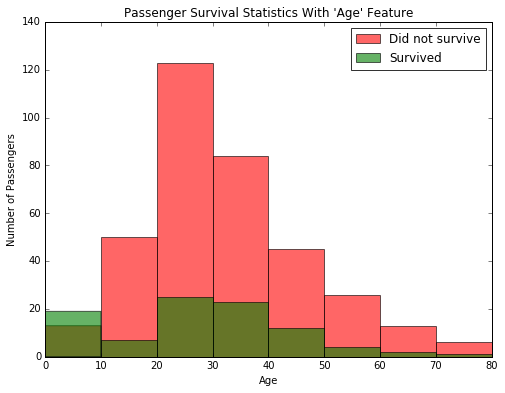

In [26]:
survival_stats(data, outcomes, 'Age', ["Sex == 'male'"])

Examining the survival statistics, the majority of males younger then 10 survived the ship sinking, whereas most males age 10 or older *did not survive* the ship sinking. Let's continue to build on our previous prediction: If a passenger was female, then we will predict they survive. If a passenger was male and younger than 10, then we will also predict they survive. Otherwise, we will predict they do not survive.  
Fill in the missing code below so that the function will make this prediction.  
**Hint:** You can start your implementation of this function using the prediction code you wrote earlier from `predictions_1`.

In [27]:
def predictions_2(data):
    """ Model with two features: 
            - Predict a passenger survived if they are female.
            - Predict a passenger survived if they are male and younger than 10. """
    
    predictions = []
    for _, passenger in data.iterrows():
        
        if passenger['Sex']== 'female':
            predictions.append(1)
        else: 
            if passenger['Age']<10:
                predictions.append(1)
            else:  #males older than 10 predicted to not survive
                predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_2(data)

### Question 3
*How accurate would a prediction be that all female passengers and all male passengers younger than 10 survived?*  
**Hint:** Run the code cell below to see the accuracy of this prediction.

In [28]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 79.35%.


**Answer**: 79.35%

Adding the feature **Age** as a condition in conjunction with **Sex** improves the accuracy by a small margin more than with simply using the feature **Sex** alone. Now it's your turn: Find a series of features and conditions to split the data on to obtain an outcome prediction accuracy of at least 80%. This may require multiple features and multiple levels of conditional statements to succeed. You can use the same feature multiple times with different conditions.   
**Pclass**, **Sex**, **Age**, **SibSp**, and **Parch** are some suggested features to try.

Use the `survival_stats` function below to to examine various survival statistics.  
**Hint:** To use mulitple filter conditions, put each condition in the list passed as the last argument. Example: `["Sex == 'male'", "Age < 18"]`

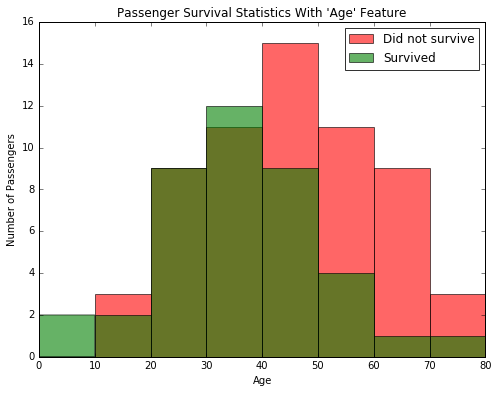

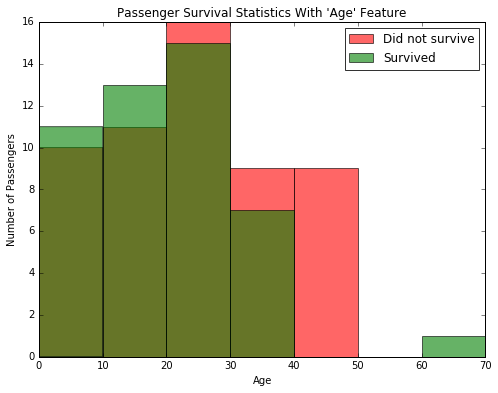

In [29]:
survival_stats(data, outcomes, 'Age', ["Sex == 'male'", "Pclass == 1"])

survival_stats(data, outcomes, 'Age', ["Sex == 'female'", "Pclass == 3"])


After exploring the survival statistics visualization, fill in the missing code below so that the function will make your prediction.  
Make sure to keep track of the various features and conditions you tried before arriving at your final prediction model.  
**Hint:** You can start your implementation of this function using the prediction code you wrote earlier from `predictions_2`.

In [30]:
def predictions_3(data):
    """ Model with multiple features. Makes a prediction with an accuracy of at least 80%. """
    
    predictions = []
    for _, passenger in data.iterrows():
        
        if passenger['Sex']== 'female':
            if passenger['Pclass']==3 and passenger['Age']>=40 and passenger['Age']<50: 
                predictions.append(0)
            else:
                predictions.append(1)

        else: #males
            if passenger['Age']<10: #males under 10
                predictions.append(1)
            else:  #males older than 10 predicted to not survive
                if passenger['Pclass']==1 and passenger['Age']>=20 and passenger['Age']<40:   
                                                                    #1st class between 10-40 males 
                    predictions.append(1)                           #are predicted to survive
                else:
                    predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_3(data)

### Question 4
*Describe the steps you took to implement the final prediction model so that it got an accuracy of at least 80%. What features did you look at? Were certain features more informative than others? Which conditions did you use to split the survival outcomes in the data? How accurate are your predictions?*  
**Hint:** Run the code cell below to see the accuracy of your predictions.

In [31]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 80.47%.


**Answer**: Females are predicted to survive, and also males under 10. 

Remaining males are to be examined: I checked how class affected men's survival, plotting statistics for each class vs age for men. Concretely, I found men from "1st class" with ages between 20-40 survive.

Re-examining women: finally I took a look to how class affected women (I plotted survival statistics for  1si, 2nd and 3rd class) and I saw how 3rd class women have higher death rates. Plotting 3rd class women survival rates vs age it is observed that women between 40-50 are predicted to die.

**Accuracy**: 80.47%

# Conclusion

Congratulations on what you've accomplished here! You should now have an algorithm for predicting whether or not a person survived the Titanic disaster, based on their features. In fact, what you have done here is a manual implementation of a simple machine learning model, the _decision tree_. In a decision tree, we split the data into smaller groups, one feature at a time. Each of these splits will result in groups that are more homogeneous than the original group, so that our predictions become more accurate. The advantage of having a computer do things for us is that it will be more exhaustive and more precise than our manual exploration above. [This link](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) provides another introduction into machine learning using a decision tree.

A decision tree is just one of many algorithms that fall into the category of _supervised learning_. In this Nanodegree, you'll learn about supervised learning techniques first. In supervised learning, we concern ourselves with using features of data to predict or model things with objective outcome labels. That is, each of our datapoints has a true outcome value, whether that be a category label like survival in the Titanic dataset, or a continuous value like predicting the price of a house.

### Question 5
*Can you think of an example of where supervised learning can be applied?*  
**Hint:** Be sure to note the outcome variable to be predicted and at least two features that might be useful for making the predictions.

**Answer**: One example of supervised learning can be medical diagnosis, i.e. maligne tumor diagnosis.

Features could be the diameter of the tumor, the age of the patient and the gender. The output could be whether the tumor is maligne or not.


maligne= diagnosis(diameter_of_tumor, age_of_patient, gender_of_patient)

INPUT VARIABLES: diameter of tumor, age and gender of the patient

OUTPUT: malignancy of the tumor

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.